# Fuentes de Limpieza

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga de datos (csv)
Se cargan la base de datos (CSV) para trabajar con estos

In [67]:
direccionTrain = 'apartments_for_rent_classified_10K.csv'
data_original = pd.read_csv(direccionTrain, sep=';', encoding='latin1')
data_original.shape

(10000, 22)

# 2. Entendimientos de los datos

In [68]:
data_original.describe()


,id,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,1.000000e+04,9966.000000,9993.000000,10000.000000,10000.000000,9990.000000,9990.000000,1.000000e+04
mean,5.623396e+09,1.380544,1.744021,1486.277500,945.810500,37.695162,-94.652247,1.574891e+09
std,7.021025e+07,0.615410,0.942354,1076.507968,655.755736,5.495851,15.759805,3.762395e+06
min,5.508654e+09,1.000000,0.000000,200.000000,101.000000,21.315500,-158.022100,1.568744e+09
25%,5.509248e+09,1.000000,1.000000,949.000000,649.000000,33.679850,-101.301700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,1270.000000,802.000000,38.809800,-93.651600,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1695.000000,1100.000000,41.349800,-82.209975,1.577359e+09
max,5.668663e+09,8.500000,9.000000,52500.000000,40000.000000,61.594000,-70.191600,1.577362e+09


# 3. Limpieza de datos

### 3.1 Selección de variables por valores unicos

Para la selección de variables, se eliminarán aquellas que son irrelevantes para los modelos, como las que contienen un único valor constante. En este caso, se retirarán las variables *currency* y *fee*, ya que no aportan información útil al análisis.

In [69]:
# Eliminar columnas con un solo valor único como es currency y fee
columns_to_drop = data_original.nunique()[data_original.nunique() == 1].index
data_filtered_1 = data_original.drop(columns=columns_to_drop)
data_filtered_1.shape

(10000, 20)

### 3.2 Selección de variables por correlación

Dado que las columnas `id` y `time` tienen una correlación perfecta (1), se decidió eliminar ambas variables. Una correlación de 1 indica que ambas contienen exactamente la misma información, lo que las hace redundantes. Además, el significado de estas variables no aporta valor al modelo: `id` es únicamente un identificador sin relevancia predictiva, y `time`, aunque representa cuándo se creó el anuncio, no es útil para estimar el precio de los apartamentos. Por lo tanto, se eliminan ambas para evitar redundancias y optimizar el conjunto de datos.

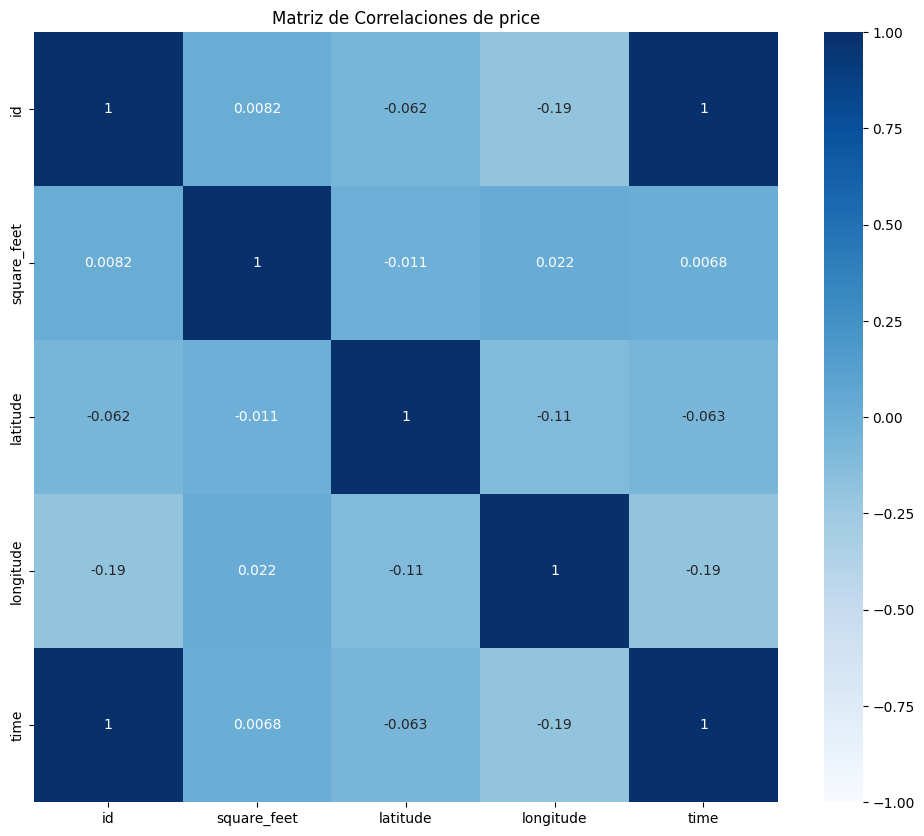

In [70]:
numerical_columns = data_original.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(['bathrooms', 'bedrooms', 'price'])
correlation_matrix = pd.DataFrame(data_original, columns=numerical_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="Blues", vmin=-1, vmax=1, annot=True)
plt.title("Matriz de Correlaciones de price")
plt.show()

In [71]:
data_filtered_2 = data_filtered_1.drop(columns=['id', 'time'])
data_filtered_2.shape

(10000, 18)

### 3.3 Selección de variables por modelo de negocio

Se decidió eliminar la columna `price_display`, ya que contiene la misma información que la columna `price`, la cual es nuestra variable objetivo en el modelo. Mantener ambas variables sería redundante y no aportaría valor adicional al análisis. Además, la presencia de `price_display` podría introducir ruido en el modelo y afectar su desempeño, ya que el modelo estaría procesando información duplicada. Por lo tanto, se prioriza conservar únicamente `price` como la representación del valor objetivo.

In [72]:
data_filtered_3 = data_filtered_2.drop(columns=['price_display'])
data_filtered_3.shape

(10000, 17)

Se decidió procesar la columna `price_type` para unificar los valores de la variable `price` en términos mensuales, ya que la mayoría de los datos ya están expresados en esta unidad. Para los registros donde `price_type` sean valores semanales, se multiplicará el `price` por 4 para convertirlos a valores mensuales. Por otro lado, se eliminarán los registros donde `price_type` tenga el valor `Monthly|Weekly`, ya que este no especifica si el precio corresponde a un mes o una semana, lo que podría introducir errores en el análisis.

In [73]:
data_filtered_4 = data_filtered_3.copy()
data_filtered_4.loc[data_filtered_4['price_type'] == 'Weekly', 'price'] *= 4

# Eliminar los registros con price_type 'Monthly|Weekly'
data_filtered_4 = data_filtered_4[data_filtered_4['price_type'] != 'Monthly|Weekly']

# Eliminar la columna price_type, ya que ya no es necesaria
data_filtered_4.drop(columns=['price_type'], inplace=True)

data_filtered_4.shape


(9999, 16)

### 3.3 Limpieza de datos por datos nulos

Para la limpieza de los datos, se decidió imputar los valores nulos de las variables **latitude** y **longitude** con la mediana, dado que la cantidad de datos faltantes es mínima y esta estrategia preserva la distribución central de las coordenadas. En el caso de **bathrooms** y **bedrooms**, se optó por completar los valores nulos con el promedio, ya que son variables numéricas. Aunque inicialmente parecen ser categóricas, al representar cantidades discretas, se pueden tratar como variables continuas y luego redondear el promedio al entero más cercano para mantener consistencia en su interpretación. Esto asegura que los datos estén completos sin introducir sesgos significativos en el análisis. Para las demas variables se hara el analisis despues.

In [74]:
data_filtered_4.isnull().sum() /data_filtered_4.shape[0] * 100
variables_con_nulos = data_filtered_4.columns[data_filtered_4.isnull().sum() > 0]
nulos_df = pd.DataFrame({
    'Cantidad de Nulos': data_filtered_4.isnull().sum()[variables_con_nulos],
    'Porcentaje de Nulos': data_filtered_4.isnull().sum()[variables_con_nulos] / data_filtered_4.shape[0] * 100,
    'Tipo de Dato': data_filtered_4.dtypes[variables_con_nulos]
})
nulos_df

,Cantidad de Nulos,Porcentaje de Nulos,Tipo de Dato
amenities,3549,35.493549,object
bathrooms,33,0.330033,float64
bedrooms,6,0.060006,float64
pets_allowed,4163,41.634163,object
address,3326,33.263326,object
cityname,77,0.770077,object
state,77,0.770077,object
latitude,10,0.100010,float64
longitude,10,0.100010,float64


Se hacen los cambios mencionados anteriormente

In [75]:
data_filtered_5 = data_filtered_4.copy()
# Rellenar valores nulos en latitude y longitude con la mediana
data_filtered_5['latitude'] = data_filtered_5['latitude'].fillna(data_filtered_5['latitude'].median())
data_filtered_5['longitude'] = data_filtered_5['longitude'].fillna(data_filtered_5['longitude'].median())

# Rellenar valores nulos en bathrooms y bedrooms con el promedio redondeado al entero más cercano
data_filtered_5['bathrooms'] = data_filtered_5['bathrooms'].fillna(round(data_filtered_5['bathrooms'].mean()))
data_filtered_5['bedrooms'] = data_filtered_5['bedrooms'].fillna(round(data_filtered_5['bedrooms'].mean()))


Para las variables categóricas cityname y state, se decidió no eliminarlas, ya que contienen información relevante para el modelo. En su lugar, se optó por rellenar los valores nulos con una categoría especial llamada "Desconocido". Esta estrategia permite conservar la estructura de las variables y manejar los casos donde no se cuenta con información, evitando la pérdida de datos importantes y permitiendo que el modelo pueda aprender de los patrones asociados a la ausencia de valores.

In [76]:
data_filtered_5['cityname'].fillna('Desconocido', inplace=True)
data_filtered_5['state'].fillna('Desconocido', inplace=True)
data_filtered_5['pets_allowed'].fillna('Desconocido', inplace=True)
data_filtered_5['amenities'].fillna('Desconocido', inplace=True)


# Verificar que ya no haya nulos en estas columnas
print(data_filtered_5[['cityname', 'state', 'pets_allowed']].isnull().sum())


cityname        0
state           0
pets_allowed    0
dtype: int64


C:\Users\andre\AppData\Local\Temp\ipykernel_17572\1856507860.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_filtered_5['cityname'].fillna('Desconocido', inplace=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_17572\1856507860.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [77]:
data_filtered_5.head(3)

,category,title,body,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source
0,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",Desconocido,1.0,0.0,Thumbnail,Desconocido,790,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo
1,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",Desconocido,1.0,1.0,Thumbnail,Desconocido,425,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo
2,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",Desconocido,1.0,0.0,Thumbnail,Desconocido,1390,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo


### 3.4 Limpieza por Outliers

Se decidió eliminar los outliers en la variables variables continuas, ya que estos valores extremos pueden distorsionar los resultados del modelo y afectar su capacidad para realizar predicciones precisas. Este proceso permite centrarse en los datos más representativos y mejorar la calidad del análisis. Del mismo modo, se eliminaron los outliers de las demas variables continuas para obtener un mejor modelo sin valores extremos.

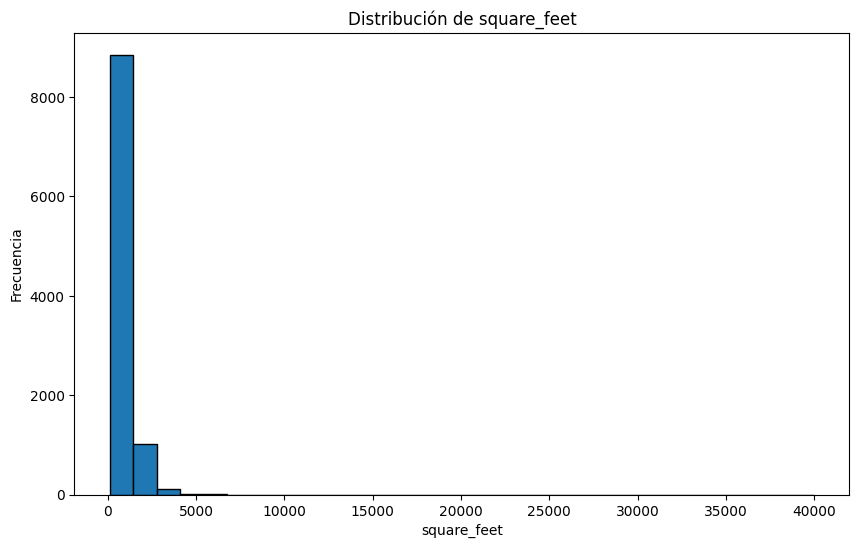

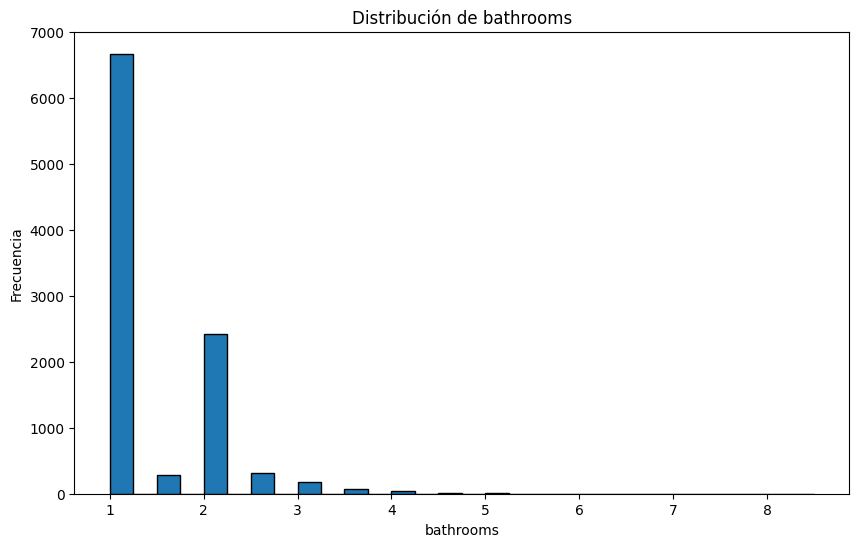

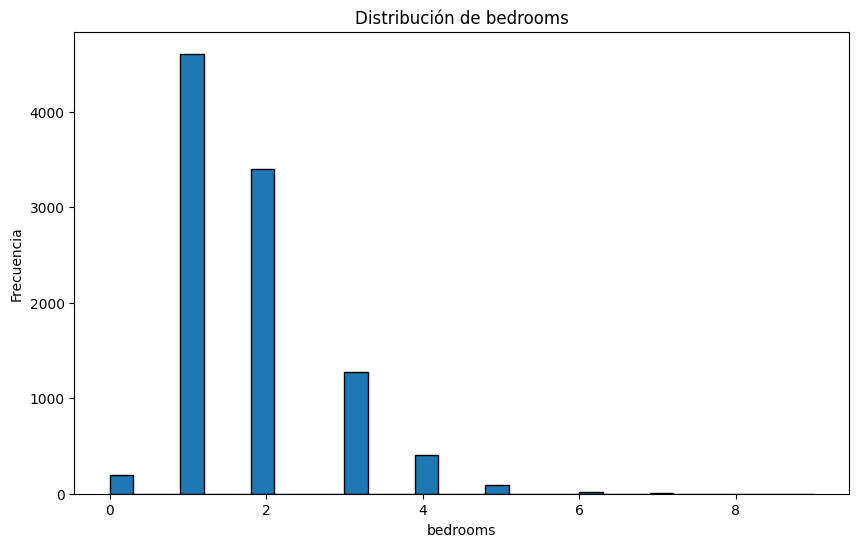

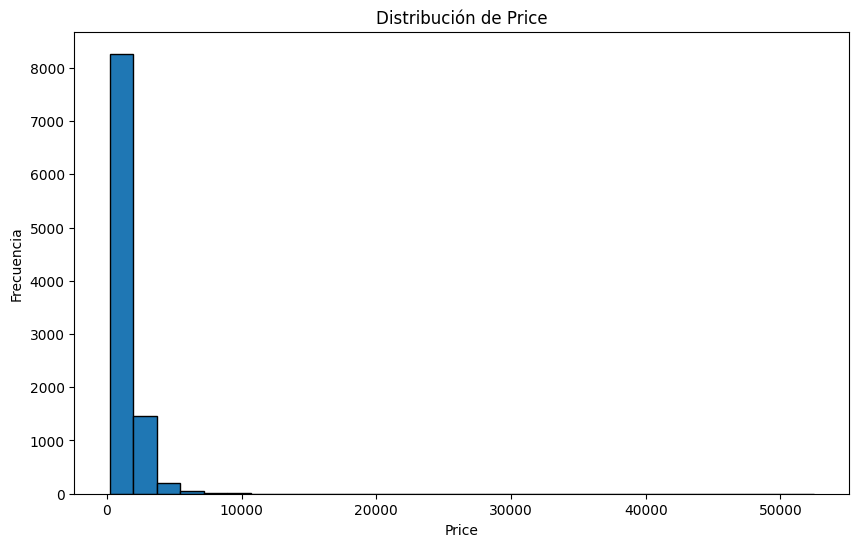

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered_5['square_feet'], bins=30, edgecolor='k')
plt.title('Distribución de square_feet')
plt.xlabel('square_feet')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_5['bathrooms'], bins=30, edgecolor='k')
plt.title('Distribución de bathrooms')
plt.xlabel('bathrooms')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_5['bedrooms'], bins=30, edgecolor='k')
plt.title('Distribución de bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_5['price'], bins=30, edgecolor='k')
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()


In [79]:
data_filtered_5['price'].describe()

count     9999.000000
mean      1486.866687
std       1077.542535
min        200.000000
25%        949.000000
50%       1270.000000
75%       1695.000000
max      52500.000000
Name: price, dtype: float64

In [80]:
# Definir una función para eliminar outliers usando el método del rango intercuartílico (IQR)
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 5 * IQR
    return df[df[columna] <= upper_bound]

data_filtered_6 = eliminar_outliers(data_filtered_5, 'price')
data_filtered_6 = eliminar_outliers(data_filtered_6, 'bedrooms')
data_filtered_6 = eliminar_outliers(data_filtered_6, 'bathrooms')
data_filtered_6 = eliminar_outliers(data_filtered_6, 'square_feet')


data_filtered_6.shape

(9888, 16)

### 3.5 Limpieza variables con frases

Se decidio quitar title dado que no se considera que el titulo de una residencia influya en su precio. Por otro lado, la columna body se decidio caracterizar poniendo la cantidad de letras que tiene para analizar esto y no lo que dice en body.

In [81]:
data_filtered_7 = data_filtered_6.copy()
data_filtered_7['Conteo body'] = [len(x) if pd.notnull(x) else 0 for x in data_filtered_7['body']]
data_filtered_7.drop(columns=['title', 'body'], inplace=True)
data_filtered_7.head(2)

,category,amenities,bathrooms,bedrooms,has_photo,pets_allowed,price,square_feet,address,cityname,state,latitude,longitude,source,Conteo body
0,housing/rent/apartment,Desconocido,1.0,0.0,Thumbnail,Desconocido,790,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,183
1,housing/rent/apartment,Desconocido,1.0,1.0,Thumbnail,Desconocido,425,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,154


Como se puede observar, en un conjunto de datos de 10,000 registros, las variable *address* presenta un alto porcentaje de valores nulos con un 33.49%. Además, esta variables son de tipo *object*, lo que dificulta su uso en modelos predictivos sin una transformación adecuada. Dado que su relación directa con el precio del arriendo no es clara y que su eliminación no afectará significativamente la calidad del análisis, se ha decidido descartarla para optimizar el procesamiento de los datos y evitar sesgos derivados de imputaciones innecesarias.

In [82]:
data_filtered_7.isnull().sum() /data_filtered_7.shape[0] * 100
variables_con_nulos = data_filtered_7.columns[data_filtered_7.isnull().sum() > 0]
nulos_df = pd.DataFrame({
    'Cantidad de Nulos': data_filtered_7.isnull().sum()[variables_con_nulos],
    'Porcentaje de Nulos': data_filtered_7.isnull().sum()[variables_con_nulos] / data_filtered_7.shape[0] * 100,
    'Tipo de Dato': data_filtered_7.dtypes[variables_con_nulos]
})
nulos_df

,Cantidad de Nulos,Porcentaje de Nulos,Tipo de Dato
address,3312,33.495146,object


In [83]:
data_filtered_8 = data_filtered_7.copy()
data_filterede_8 = data_filtered_8.drop(columns=['address'], inplace=True)


### 3.6 Eliminar los valores duplicados

Se eliminan los valores duplicados para garantizar la integridad de los datos y prevenir inconsistencias en el modelo.

In [84]:
data_filtered_9 = data_filtered_8.copy()
filas_antes = data_filtered_9.shape[0]
data_filtered_9 = data_filtered_9.drop_duplicates()
filas_despues = data_filtered_9.shape[0]
duplicados_eliminados = filas_antes - filas_despues
print(f"Cantidad de valores duplicados eliminados: {duplicados_eliminados}")



Cantidad de valores duplicados eliminados: 35


# 4. Analisis descriptivo de los datos limpios

In [85]:
datos_limpios = data_filtered_9.copy()
datos_limpios.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude,Conteo body
count,9853.000000,9853.000000,9853.000000,9853.000000,9853.000000,9853.000000,9853.000000
mean,1.356135,1.718157,1427.800873,916.425353,37.710218,-94.531400,411.998275
std,0.563364,0.904623,717.962298,443.353688,5.497746,15.676733,327.619967
min,1.000000,0.000000,200.000000,101.000000,21.315500,-158.022100,6.000000
25%,1.000000,1.000000,945.000000,647.000000,33.679500,-100.756200,151.000000
50%,1.000000,2.000000,1260.000000,800.000000,38.848800,-93.651600,289.000000
75%,2.000000,2.000000,1683.000000,1095.000000,41.353400,-82.120500,755.000000
max,5.000000,7.000000,5355.000000,3350.000000,61.594000,-70.191600,1024.000000


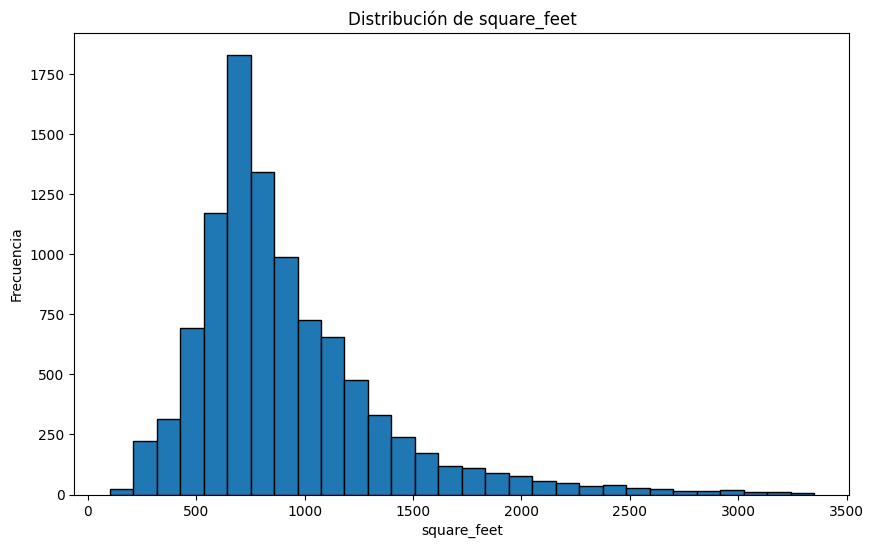

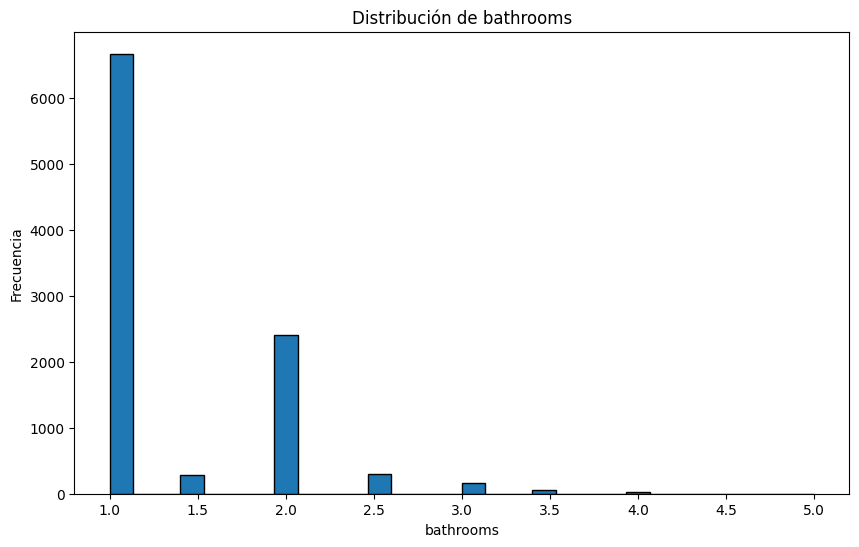

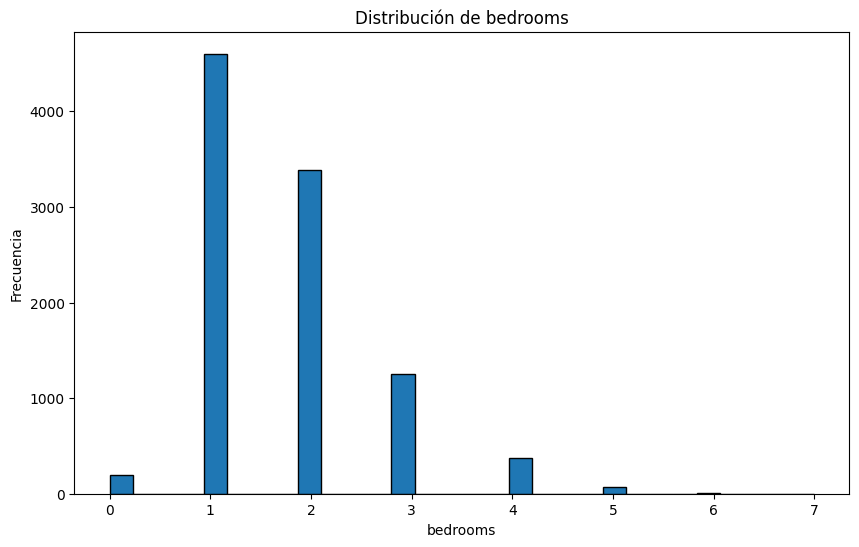

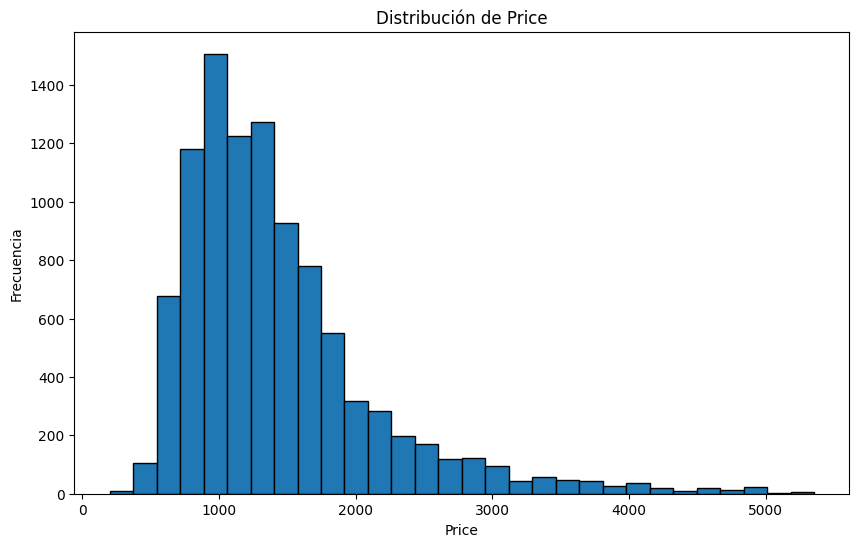

In [86]:
plt.figure(figsize=(10, 6))
plt.hist(data_filtered_6['square_feet'], bins=30, edgecolor='k')
plt.title('Distribución de square_feet')
plt.xlabel('square_feet')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_6['bathrooms'], bins=30, edgecolor='k')
plt.title('Distribución de bathrooms')
plt.xlabel('bathrooms')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_6['bedrooms'], bins=30, edgecolor='k')
plt.title('Distribución de bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(data_filtered_6['price'], bins=30, edgecolor='k')
plt.title('Distribución de Price')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()

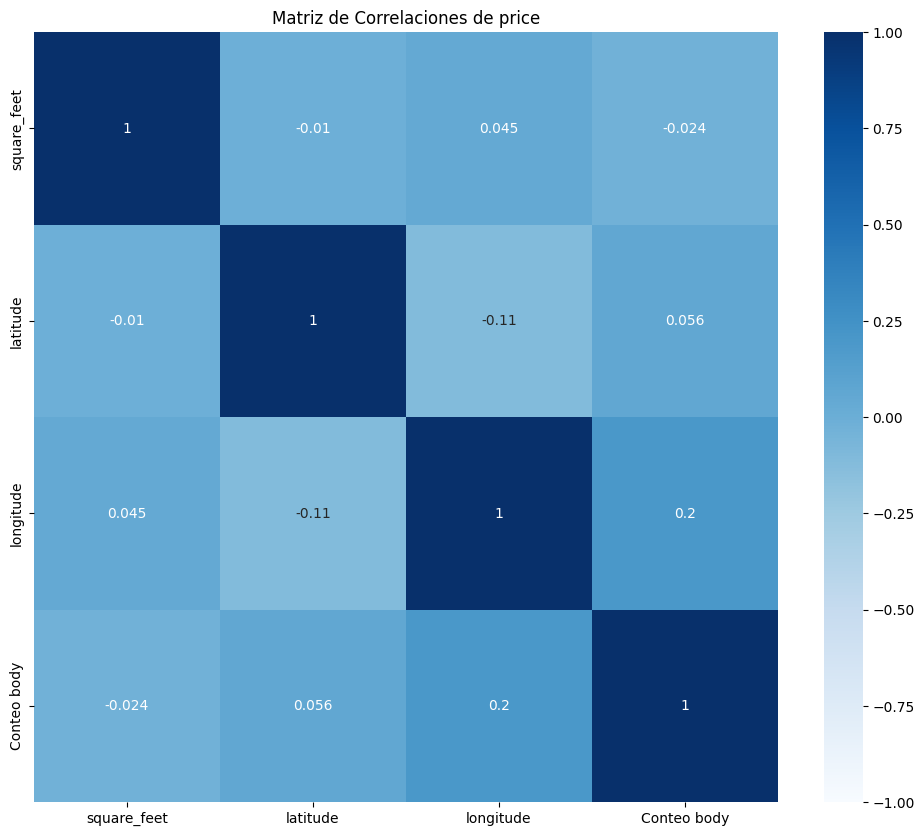

In [87]:
numerical_columns = datos_limpios.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(['bathrooms', 'bedrooms', 'price'])
correlation_matrix = pd.DataFrame(datos_limpios, columns=numerical_columns).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="Blues", vmin=-1, vmax=1, annot=True)
plt.title("Matriz de Correlaciones de price")
plt.show()

In [88]:
category_counts = datos_limpios.nunique()
categorical_columns_filtered = category_counts[category_counts < 52].index
categorical_columns_filtered

Index(['category', 'bathrooms', 'bedrooms', 'has_photo', 'pets_allowed',
       'source'],
      dtype='object')

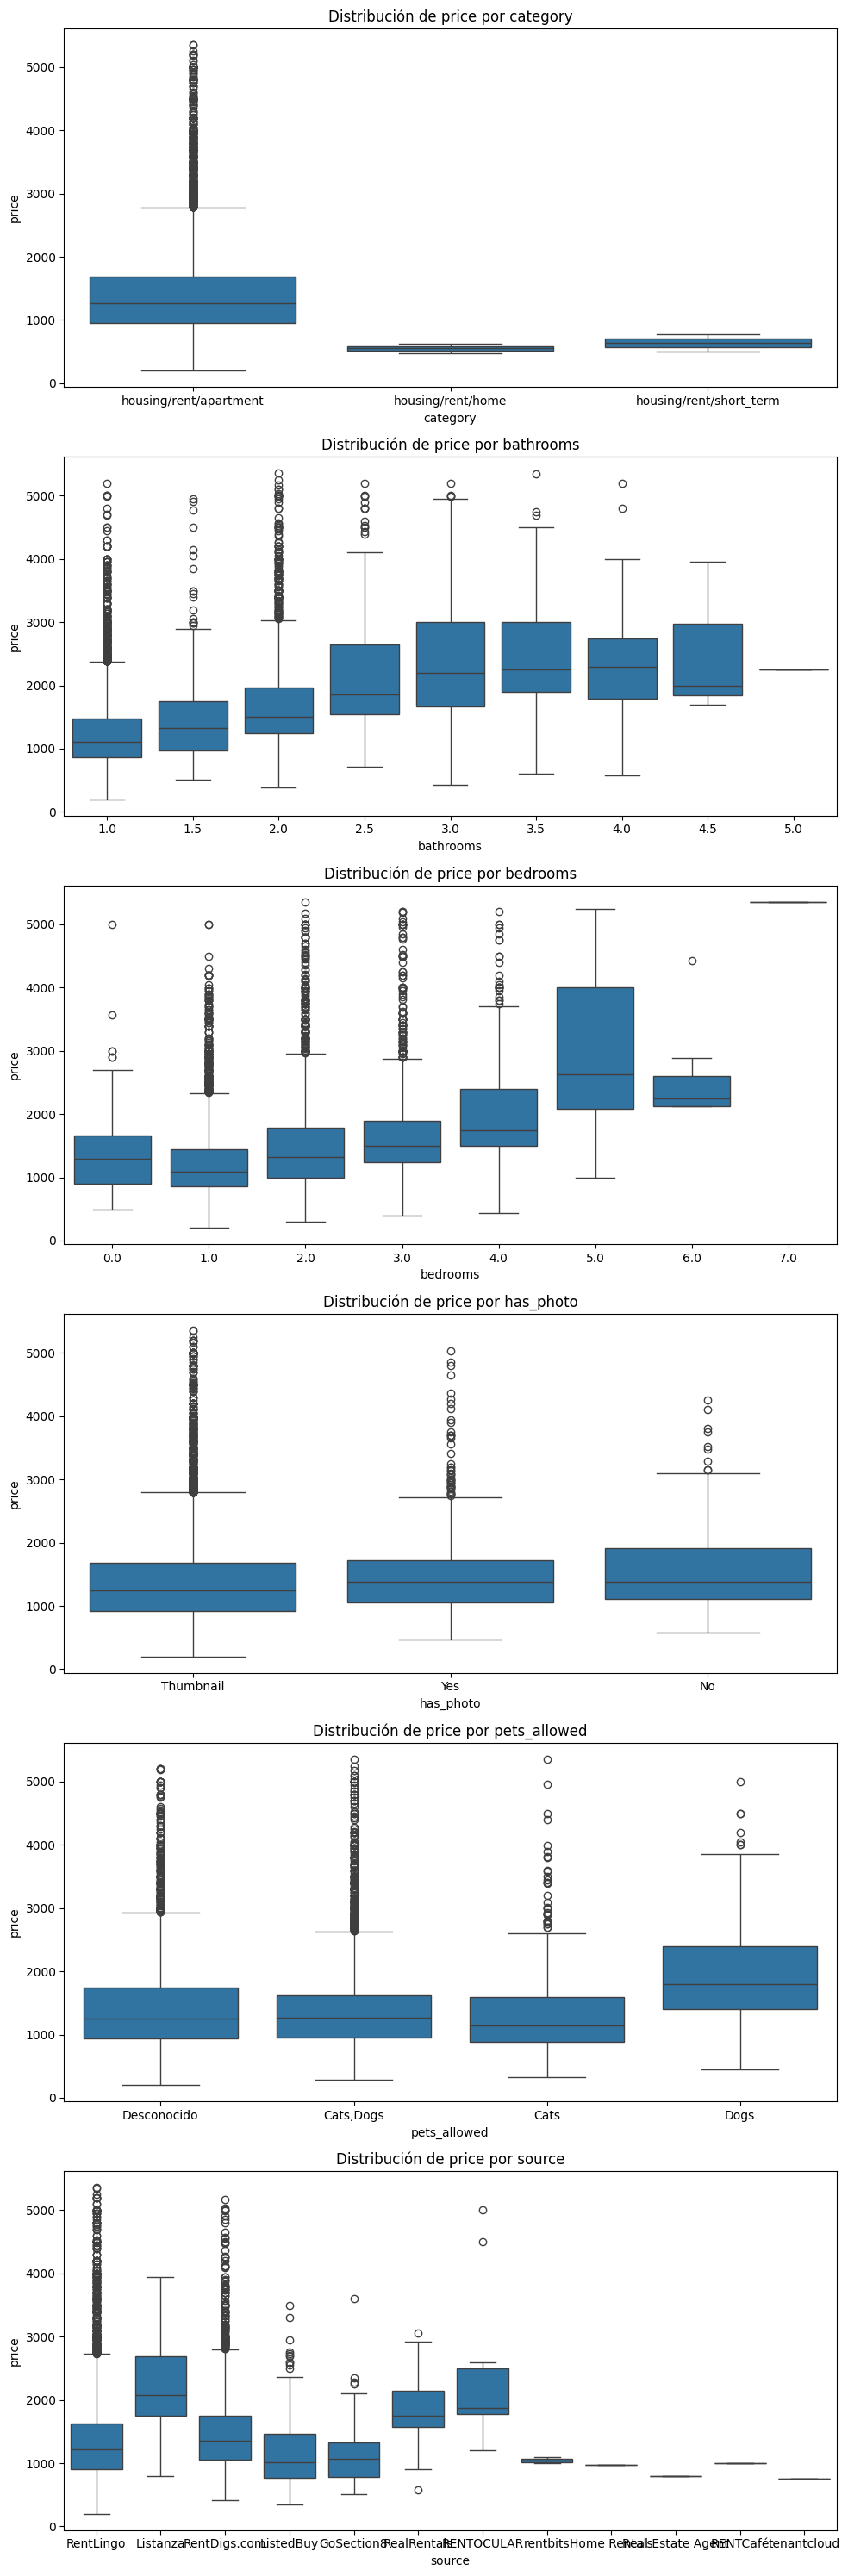

In [89]:
fig, axes = plt.subplots(nrows=len(categorical_columns_filtered), ncols=1, figsize=(10, 5 * len(categorical_columns_filtered)))

for ax, feature in zip(axes, categorical_columns_filtered):
    sns.boxplot(data=datos_limpios, x=feature, y="price", ax=ax)
    ax.set_title(f"Distribución de price por {feature}")

plt.tight_layout()
plt.show()